In [2]:

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt


def load_images_from_folder(folder_path, image_size=(224, 224), validation_split=0):
   
    images = []
    labels = []
    
    # Get all subfolders (classes)
    class_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    
    for class_name in class_folders:
        class_path = os.path.join(folder_path, class_name)
        print(f"Loading images from class: {class_name}")
        
        # Get all images in the class folder
        for image_name in os.listdir(class_path):
            if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(class_path, image_name)
                
                # Read and preprocess the image
                image = cv2.imread(image_path)
                if image is not None:
                    # Convert BGR to RGB
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    # Resize image
                    image = cv2.resize(image, image_size)
                    # Normalize pixel values to [0, 1]
                    image = image / 255.0

                    images.append(image)
                    match class_name:
                        case 'NoTumour':
                            labels.append("0")
                        case 'Meningioma':
                            labels.append("1")
                        case 'Pituitary':
                            labels.append("2")
                        case 'Glioma':
                            labels.append("3")
                        case _:
                            labels.append(class_name)
         
    images = np.array(images)
    labels = np.array(labels)
    
    if validation_split > 0:
        from sklearn.model_selection import train_test_split
        X_train, X_val, y_train, y_val = train_test_split(
            images, labels, 
            test_size=validation_split,
            random_state=42,
            stratify=labels  # Ensure balanced split across classes
        )
        return X_train, X_val, y_train, y_val
    else:
        return images, labels

 # Load training data
train_path = "H:/School/Year3/MachineLearning/BrainTumourDetection-AISE3000/train"
X_train, y_train= load_images_from_folder(train_path)
print(f"Training data shape: {X_train.shape}")
print(f"Number of training labels: {len(y_train)}")

#Data is initially split into 80% train and 20% test so splitting the test set gives an 80/10/10 train/val/test split
# Load testing data and split into test and validation sets
test_path = "H:/School/Year3/MachineLearning/BrainTumourDetection-AISE3000/test"
X_test, X_val, y_test, y_val = load_images_from_folder(test_path, validation_split=0.5)
print(f"Testing data shape: {X_test.shape}")
print(f"Number of testing labels: {len(y_test)}")   
print(f"Validation data shape: {X_val.shape}")
print(f"Number of validation labels: {len(y_val)}")


Loading images from class: glioma
Loading images from class: meningioma
Loading images from class: notumor
Loading images from class: pituitary
Training data shape: (5723, 224, 224, 3)
Number of training labels: 5723
Loading images from class: glioma
Loading images from class: meningioma
Loading images from class: notumor
Loading images from class: pituitary
Testing data shape: (715, 224, 224, 3)
Number of testing labels: 715
Validation data shape: (715, 224, 224, 3)
Number of validation labels: 715



Visualizing training samples:


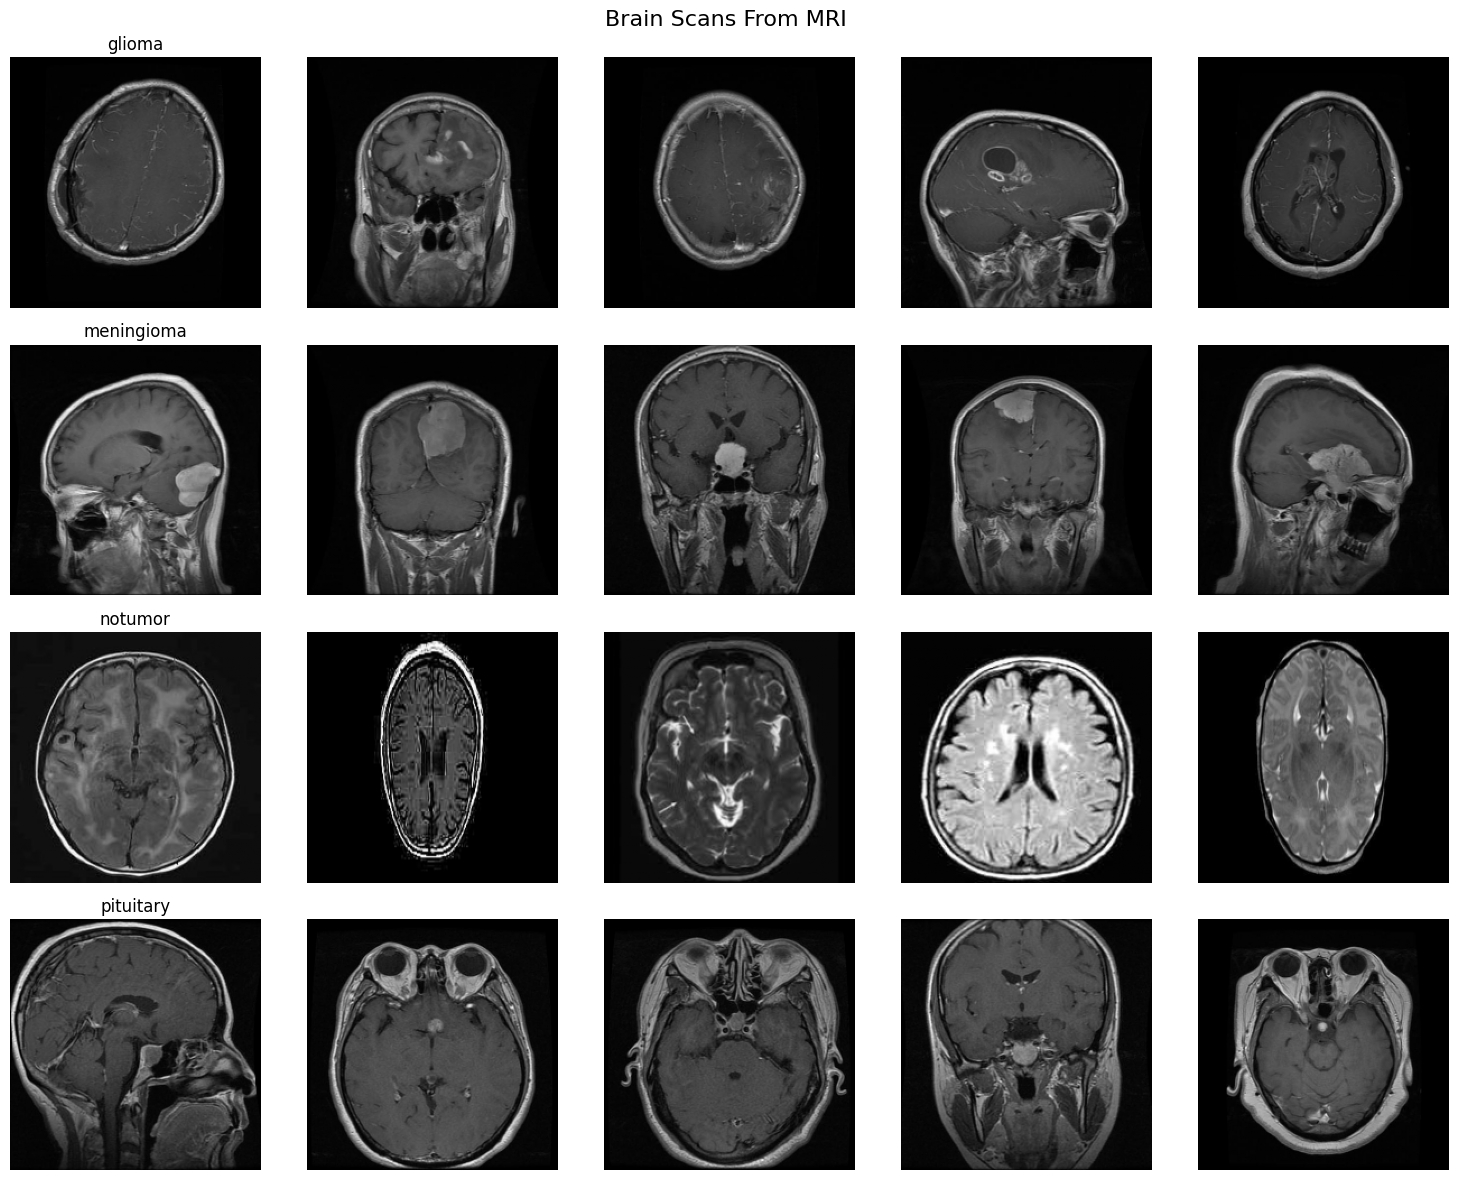


Visualizing validation samples:


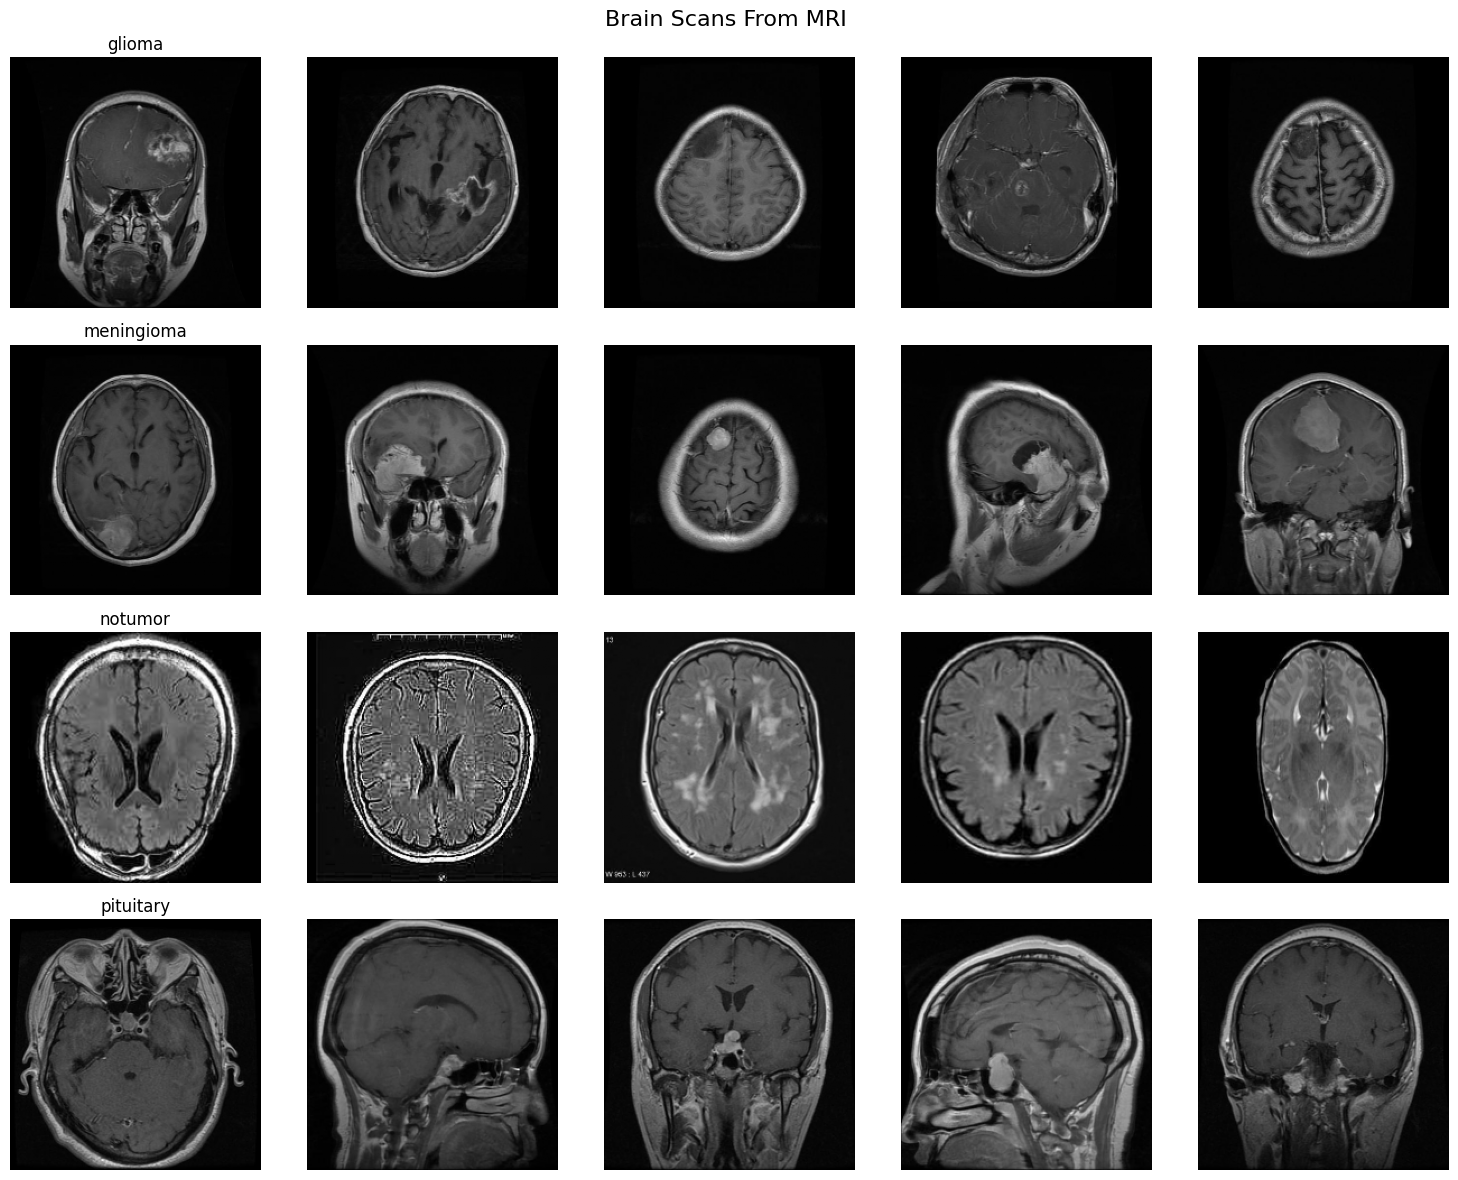


Visualizing testing samples:


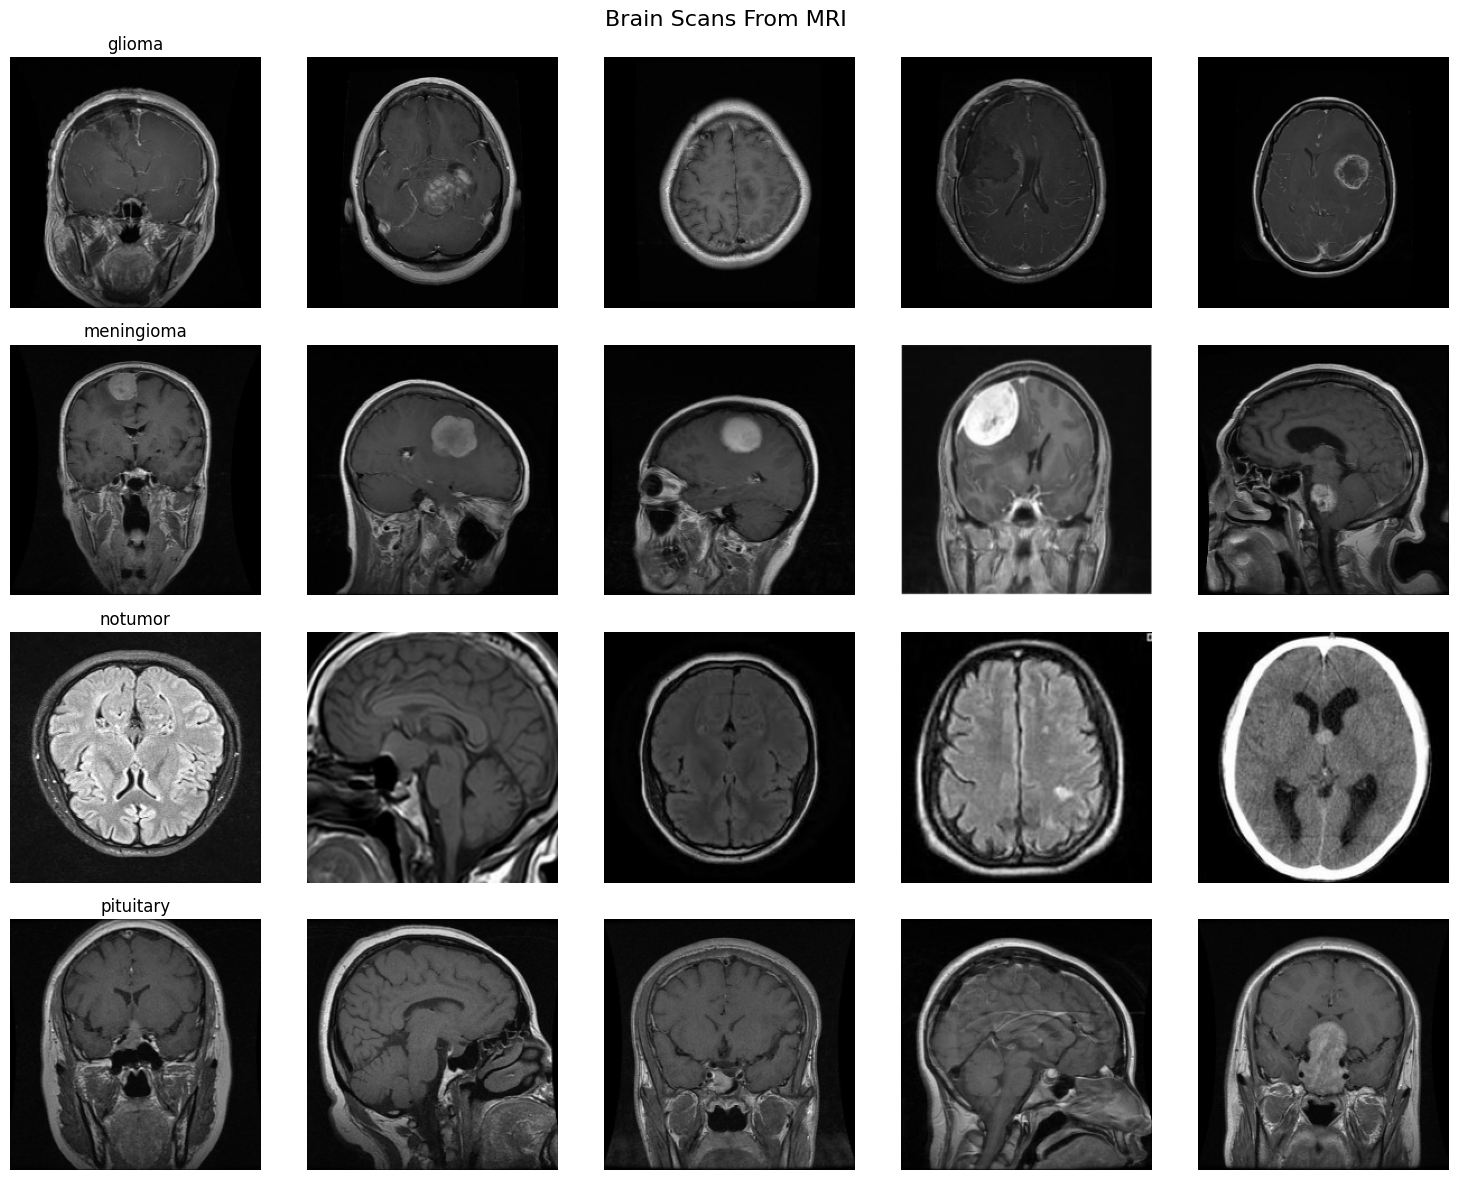

In [3]:

def visualize_samples(images, labels, num_samples_per_class=5):
    """
    Visualize sample images from each class in a grid
    """
    # Get unique classes
    unique_classes = np.unique(labels)
    num_classes = len(unique_classes)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(num_classes, num_samples_per_class, 
                            figsize=(15, 3*num_classes))
    fig.suptitle('Brain Scans From MRI ', fontsize=16)
    
    # Plot samples from each class
    for i, class_name in enumerate(unique_classes):
        # Get indices for current class
        class_indices = np.where(labels == class_name)[0]
        
        # Randomly select samples
        selected_indices = np.random.choice(class_indices, 
                                          min(num_samples_per_class, len(class_indices)), 
                                          replace=False)
        
        # Plot each sample
        for j, idx in enumerate(selected_indices):
            axes[i, j].imshow(images[idx])
            axes[i, j].axis('off')
            if j == 0:  # Only show class name on first image of each row
                axes[i, j].set_title(class_name)
    
    plt.tight_layout()
    plt.show()


print("\nVisualizing training samples:")
visualize_samples(X_train, y_train)
print("\nVisualizing validation samples:")
visualize_samples(X_val, y_val)
print("\nVisualizing testing samples:")
visualize_samples(X_test, y_test)

In [ ]:

from tensorflow.keras import layers, models


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='softmax')) 

 # 4 classes:
# 0: notumor, 1: meningioma, 2: pituitary, 3: glioma
label_map = {
    'notumor': 0,
    'meningioma': 1,
    'pituitary': 2,
    'glioma': 3,
   
}

def encode_labels(y):
    # Normalize to lowercase string then map
    return np.array([label_map[str(lbl).lower()] for lbl in y], dtype=np.int32)

# Encode y arrays (they are string arrays in the notebook)
y_train_enc = encode_labels(y_train)
y_val_enc = encode_labels(y_val)
y_test_enc = encode_labels(y_test)

print("Encoded label distribution (train):", np.unique(y_train_enc, return_counts=True))

model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train_enc, epochs=10, 
                    validation_data=(X_val, y_val_enc))
test_loss, test_acc = model.evaluate(X_test, y_test_enc, verbose=2)
print(f"\nTest accuracy: {test_acc}")

Encoded label distribution (train): (array([0, 1, 2, 3], dtype=int32), array([1600, 1420, 1406, 1297]))


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,825,540 (10.78 MB)

 Trainable params: 2,825,540 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 208ms/step - accuracy: 0.6755 - loss: 0.7799 - val_accuracy: 0.8238 - val_loss: 0.4621
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 206ms/step - accuracy: 0.8558 - loss: 0.3720 - val_accuracy: 0.8587 - val_loss: 0.3641
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 205ms/step - accuracy: 0.9184 - loss: 0.2146 - val_accuracy: 0.9189 - val_loss: 0.2860
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 38s 214ms/step - accuracy: 0.9588 - loss: 0.1209 - val_accuracy: 0.9385 - val_loss: 0.2414
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 204ms/step - accuracy: 0.9801 - loss: 0.0577 - val_accuracy: 0.9063 - val_loss: 0.3609
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 36s 199ms/step - accuracy: 0.9834 - loss: 0.0465 - val_accuracy: 0.9524 - val_loss: 0.2300
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 36s 199ms/step - accuracy: 0.9893 - loss: 0.0297 - val_accuracy: 0.9371 - val_loss: 0.2436
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 208ms/step - accuracy: 0.9921 - loss: 0